In [2]:
from tensorflow.keras import layers, models, datasets
import tensorflow as tf
import matplotlib.pyplot as plt

In [30]:
# initializing our constants 
IMAGE_SIZE = 224
BATCH_SIZE = 64
CHANNELS = 3

In [31]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\DEEP LEARNING\DELTA 3.0',
    image_size =( IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 1514 files belonging to 5 classes.


In [32]:
classes = dataset.class_names

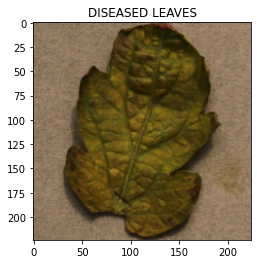

In [33]:
for image_batch, image_label in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(classes[image_label[0]])

In [34]:
def function_to_split(ds, train_split = 0.8, valid_split = 0.1, test_split = 0.1, shuffle = True , shuffle_size = 10000):
    assert (train_split + valid_split + test_split ) == 1 
    
    if shuffle:
        ds.shuffle(shuffle_size, seed = 12)
    
    ds_size = len(ds)
    
    train_size = int(train_split* ds_size)
    valid_size = int(valid_split * ds_size)
    
    train_ds = ds.take(train_size )
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds, valid_ds, test_ds

In [35]:
train_ds, valid_ds, test_ds = function_to_split(dataset)

In [36]:
len(test_ds),len(train_ds)

(3, 19)

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [38]:
def csp(train_ds, valid_ds , test_ds):
    train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    valid_ds = valid_ds.cache().shuffle(1000).prefetch(AUTOTUNE)  
    test_ds =test_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    return train_ds, valid_ds, test_ds

In [39]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [40]:

data_augmentation = tf.keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])
def function_to_preprocess(ds, shuffle = False, augment = False):
    ds = ds.map(lambda x,y : (resize_and_rescale(x),y),AUTOTUNE)
    if shuffle:
        ds.shuffle(10000)
        
    if augment:
        ds = ds.map(lambda x,y : (data_augmentation(x,training = True),y),AUTOTUNE)
        
    return ds.prefetch(AUTOTUNE)
    
        

In [41]:
train_ds = train_ds.map(lambda x,y : (data_augmentation(x),y),AUTOTUNE)

In [42]:
len(train_ds)

19

In [43]:
# train_ds = prepare(train_ds, shuffle=True, augment=True)

In [44]:
# function_to_preprocess(dataset)

In [45]:
# INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 5
# model = models.Sequential([
#     resize_and_rescale,
    
#     layers.Conv2D(32,(3,3), activation = 'relu' , input_shape = INPUT_SHAPE ),
#     layers.MaxPool2D((2,2)),
    
#     layers.Conv2D(64, (3,3),activation = 'relu'),
#     layers.MaxPool2D((2,2)),
    
#     layers.Flatten(),
#     layers.Dense(64, activation = 'relu'),
#     layers.Dense(n_classes,activation = 'softmax')

# ])

# model.build(INPUT_SHAPE)

In [46]:
# model.summary() 

In [47]:
# model.compile(
#     optimizer = 'adam',
#      loss = 'sparse_categorical_crossentropy',
#     metrics = [ 'accuracy']
# )

In [48]:
# history = model.fit(
#     train_ds,
#     batch_size=BATCH_SIZE,
#     validation_data=valid_ds,
#     verbose=1,
#     epochs=2
# )

In [49]:
# # "# Create the base model from the pre-trained model MobileNet V2\n",
#  "base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,\n",
#  " include_top=False, \n",
#  " weights='imagenet')"
 
 
 

In [50]:
# lets create a base mode from pretrained model MobileNet V2

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights= 'imagenet')

In [51]:
base_model.trainable = False

In [52]:
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32,3, activation= 'relu'),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(6, activation = 'softmax')
    
    
])

In [53]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 2,626,854
Trainable params: 368,870
Non-trainable params: 2,257,984
_________________________________________________________________


In [54]:
model.compile(
    optimizer = 'adam',
     loss = 'sparse_categorical_crossentropy',
    metrics = [ 'accuracy']
)

In [55]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=2
)

Epoch 1/2
19/19 [==============================] - 73s 4s/step - loss: 1.4428 - accuracy: 0.5987 - val_loss: 1.5827 - val_accuracy: 0.4922
Epoch 2/2
19/19 [==============================] - 71s 4s/step - loss: 0.7034 - accuracy: 0.7352 - val_loss: 1.0131 - val_accuracy: 0.6719


In [57]:
acc = history.history['accuracy']

In [58]:
acc

[0.5986841917037964, 0.7351973652839661]

In [59]:
val_acc = history.history['val_accuracy']

In [60]:
val_acc

[0.4921875, 0.671875]

In [61]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [62]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [66]:
class_names = dataset.class_names
import numpy as np

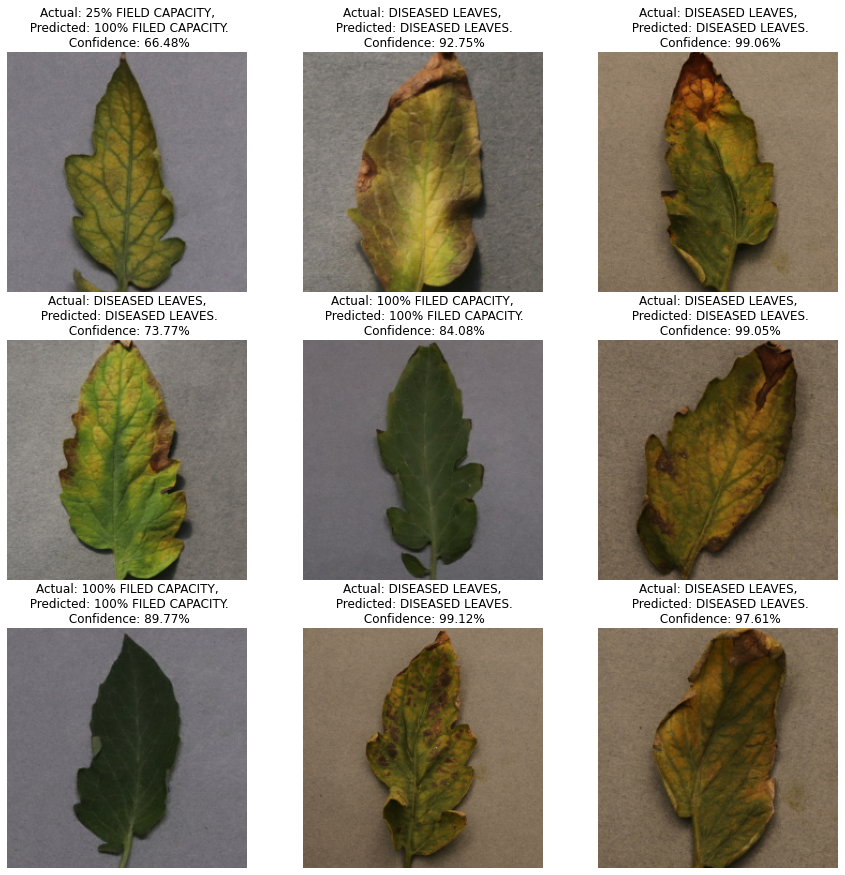

In [67]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [75]:
import os

os.chdir(r'D:\DEEP LEARNING\DELTA 3.0')
# import os


In [76]:
pwd

'D:\\DEEP LEARNING\\DELTA 3.0'

In [81]:
model.save('model.h5')



In [82]:
model.evaluate(test_ds)

3/3 [==============================] - 6s 2s/step - loss: 1.0668 - accuracy: 0.6353


[1.0667872428894043, 0.6352941393852234]